In [1]:
import os
import warnings

import act
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import pandas as pd

import numpy as np
import pyart
import xarray as xr

import cartopy.feature as cfeature
from scipy.spatial import cKDTree
import pandas as pd
from wrf import (getvar, CoordPair, vertcross, latlon_coords, to_np, destagger)
import glob
from netCDF4 import Dataset

warnings.filterwarnings("ignore")

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
path_head = '/data/home/ajmal13/blimp/scripts/bnfecorsfS14.b1/'
ds_ecorS14 = xr.open_mfdataset(os.path.join(path_head+'*.nc'))

path_head = '/data/home/ajmal13/blimp/scripts/bnfecorsfS20.b1/'
ds_ecorS20 = xr.open_mfdataset(os.path.join(path_head+'*.nc'))

path_head = '/data/home/ajmal13/blimp/scripts/bnfecorsfS30.b1/'
ds_ecorS30 = xr.open_mfdataset(os.path.join(path_head+'*.nc'))

path_head = '/data/home/ajmal13/blimp/scripts/bnfecorsfS40.b1/'
ds_ecorS40 = xr.open_mfdataset(os.path.join(path_head+'*.nc'))


In [3]:

start_plot_date = '2025-04-11T00:00:00'
end_plot_date = '2025-04-11T23:59:59'
ds_ecorS14_plot=ds_ecorS14.sel(time=slice(start_plot_date,end_plot_date))
ds_ecorS20_plot=ds_ecorS20.sel(time=slice(start_plot_date,end_plot_date))
ds_ecorS30_plot=ds_ecorS30.sel(time=slice(start_plot_date,end_plot_date))
ds_ecorS40_plot=ds_ecorS40.sel(time=slice(start_plot_date,end_plot_date))

In [4]:
sensi_flux_S14 = ds_ecorS14_plot.sensible_heat_flux.values
timestamps_S14 = ds_ecorS14_plot.time

sensi_flux_S20 = ds_ecorS20_plot.sensible_heat_flux.values
timestamps_S20 = ds_ecorS20_plot.time

sensi_flux_S30 = ds_ecorS30_plot.sensible_heat_flux.values
timestamps_S30 = ds_ecorS30_plot.time

sensi_flux_S40 = ds_ecorS40_plot.sensible_heat_flux.values
timestamps_S40 = ds_ecorS40_plot.time

In [5]:
path_head = '/data/project/ARM_Summer_School_2025/model/wrf/'
case_day = '2025041106/'

In [6]:
ds_wrf = xr.open_mfdataset(os.path.join(path_head+case_day+'run/wrfout_d01*'),concat_dim='Time',combine='nested')

In [7]:
# Pull static lat/lon at first time step
lat2d = ds_wrf['XLAT'].isel(Time=0)
lon2d = ds_wrf['XLONG'].isel(Time=0)

# Flatten and build KDTree
flat_coords = np.column_stack((lat2d.values.ravel(), lon2d.values.ravel()))
tree = cKDTree(flat_coords)

# ARM site locations
target_lat = [34.3425, 34.6538, 34.3848, 34.1788]
target_lon = [-87.3382, -87.2927, -86.9279, -87.4539]
target_coords = np.column_stack((target_lat, target_lon))

# Find nearest indices
_, flat_idx = tree.query(target_coords)
i_indices, j_indices = np.unravel_index(flat_idx, lat2d.shape)

# Create dict of site names to datasets
site_names = ['M1', 'S20', 'S30', 'S40']
site_datasets = {}

for name, i, j in zip(site_names, i_indices, j_indices):
    site_datasets[name] = ds_wrf.isel(south_north=i, west_east=j).expand_dims(site=[name])

In [8]:
ds_wrf_bnf_site = xr.concat(site_datasets.values(), dim='site')

## Compare WRF Simulation results with ECOR fluxes

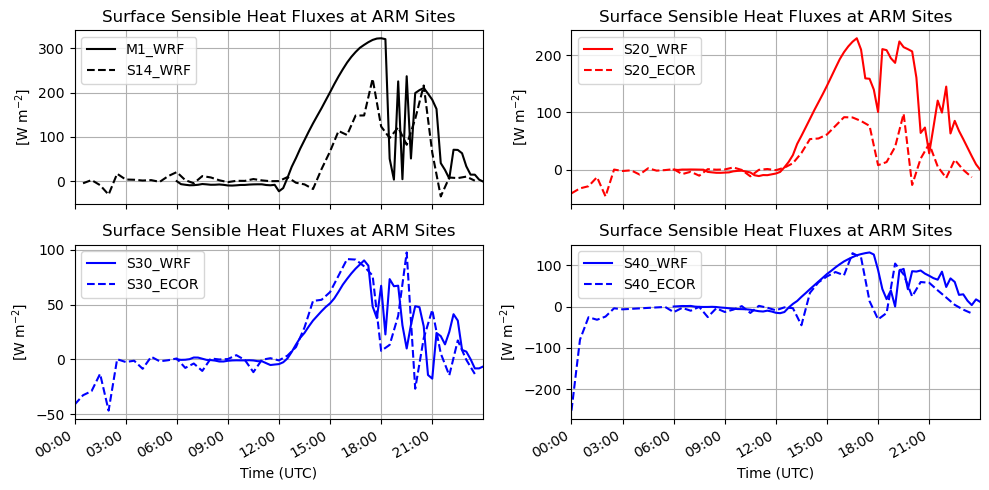

In [10]:
# Select the variables you want to plot
var1a = ds_wrf_bnf_site['HFX'] # surface sensible heat flux
#var1b = ds_wrf_bnf_site['LH'] # surface latent heat flux

#var2 = ds_wrf_bnf_site['LWP'] # liquid water path

# Make the plot
plt.figure(figsize=(10, 5))
#cols = ['k','gray','b','lightskyblue']

######################## Subplot 1 ########################
# Sensible heat fluxes
ax=plt.subplot(2,2,1)
#count = 0
#for site in var1a.site.values:
plt.plot(var1a['XTIME'], var1a.sel(site='M1'), color='black', label='M1_WRF',linestyle='solid')
plt.plot(timestamps_S14,sensi_flux_S14, color='black', label='S14_WRF',linestyle='dashed')
#    plt.plot(var1b['XTIME'], var1b.sel(site=site), c=cols[count], ls='--')
    
#    count+=1
plt.xlim([pd.Timestamp(2025,4,11,0),pd.Timestamp(2025,4,11,23,59,0)])
plt.xlabel("Time (UTC)")
plt.ylabel("[W m$^{-2}$]")
plt.title("Surface Sensible Heat Fluxes at ARM Sites")
plt.legend()
plt.grid(True)

ax1=plt.subplot(2,2,2)
#count = 0
#for site in var1a.site.values:
plt.plot(var1a['XTIME'], var1a.sel(site='S20'), color='red', label='S20_WRF',linestyle='solid')
plt.plot(timestamps_S20,sensi_flux_S20, color='red', label='S20_ECOR',linestyle='dashed')
#    plt.plot(var1b['XTIME'], var1b.sel(site=site), c=cols[count], ls='--')
    
#    count+=1
plt.xlim([pd.Timestamp(2025,4,11,0),pd.Timestamp(2025,4,11,23,59,0)])
plt.xlabel("Time (UTC)")
plt.ylabel("[W m$^{-2}$]")
plt.title("Surface Sensible Heat Fluxes at ARM Sites")
plt.legend()
plt.grid(True)

ax2=plt.subplot(2,2,3)
#count = 0
#for site in var1a.site.values:
plt.plot(var1a['XTIME'], var1a.sel(site='S30'), color='blue', label='S30_WRF',linestyle='solid')
plt.plot(timestamps_S20,sensi_flux_S20, color='blue', label='S30_ECOR',linestyle='dashed')
#    plt.plot(var1b['XTIME'], var1b.sel(site=site), c=cols[count], ls='--')
    
#    count+=1
plt.xlim([pd.Timestamp(2025,4,11,0),pd.Timestamp(2025,4,11,23,59,0)])
plt.xlabel("Time (UTC)")
plt.ylabel("[W m$^{-2}$]")
plt.title("Surface Sensible Heat Fluxes at ARM Sites")
plt.legend()
plt.grid(True)

ax3=plt.subplot(2,2,4)
#count = 0
#for site in var1a.site.values:
plt.plot(var1a['XTIME'], var1a.sel(site='S40'), color='blue', label='S40_WRF',linestyle='solid')
plt.plot(timestamps_S40,sensi_flux_S40, color='blue', label='S40_ECOR',linestyle='dashed')
#    plt.plot(var1b['XTIME'], var1b.sel(site=site), c=cols[count], ls='--')
    
#    count+=1
plt.xlim([pd.Timestamp(2025,4,11,0),pd.Timestamp(2025,4,11,23,59,0)])
plt.xlabel("Time (UTC)")
plt.ylabel("[W m$^{-2}$]")
plt.title("Surface Sensible Heat Fluxes at ARM Sites")
plt.legend()
plt.grid(True)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gcf().autofmt_xdate() # clean up labels
plt.tight_layout()
plt.show()

## Findings

1. The model seems to capture the diurnal variation of sensible heat flux well
2. The model sensible heat flux at M1 and S20 is almost double the value of ECOR derived flux values but S30 and S40 both model and ECOR values follow one another much more accurately